loss is [6.4407603e+09 4.9660206e-02 6.4407603e+09]
loss is [5.8164623e+09 4.0848529e+02 5.8164628e+09]
loss is [5.675257e+09 7.699064e+02 5.675258e+09]
loss is [5.6580434e+09 8.3290436e+02 5.6580444e+09]
loss is [5.658032e+09 8.622415e+02 5.658033e+09]
loss is [5.6559427e+09 8.8171234e+02 5.6559437e+09]
loss is [5.6567101e+09 9.0116766e+02 5.6567112e+09]
loss is [5.6569825e+09 9.2170404e+02 5.6569836e+09]
loss is [5.6558894e+09 9.4285760e+02 5.6558904e+09]
loss is [5.656505e+09 9.560734e+02 5.656506e+09]


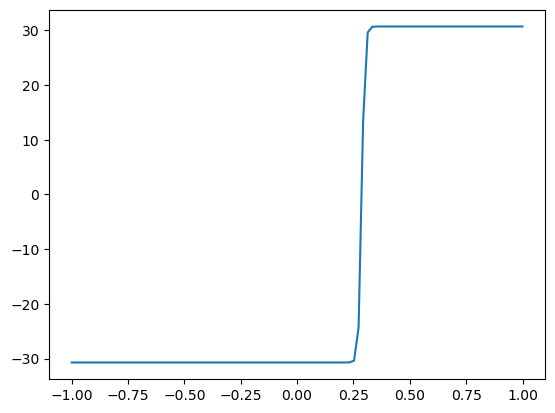

In [4]:
import sys
sys.path.append('../')

import numpy as np
import torch
import matplotlib

from user_funn.field import D1Field
from user_funn.get_net import ForwardNetwork
from user_funn.ds import get_data_loader
from user_funn.solver import CloudPointSolver
from user_funn.pde import grad

# 保证迭代参数与DEEPXDE一致
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import torch.nn as nn
class ForwardNetwork(nn.Module):
    def __init__(self, net_size_vec=[2,64,64,64,64,3]):
        super(ForwardNetwork, self).__init__()
        sqnet_para_list = []
        # like [2,128,64,32,2], iter end in idx 3(32)
        for i in range(len(net_size_vec)-2):
            sqnet_para_list.append(
                nn.Linear(net_size_vec[i],net_size_vec[i+1]),
            )
            sqnet_para_list.append(nn.Tanh())

        sqnet_para_list.append(nn.BatchNorm1d(net_size_vec[-2]))
        sqnet_para_list.append(
            nn.Linear(net_size_vec[-2],net_size_vec[-1])
            )
        
        self.linear_relu_stack = nn.Sequential(
            *sqnet_para_list
        )

    def forward(self, x):
        y = self.linear_relu_stack(x)
        return y

model = ForwardNetwork([1, 50, 50, 50, 1]).to(device)

loss_fn = torch.nn.MSELoss()

## define a pde
pde_epoch_size = 16
pde_batch_num = 1
pde_batch_size = pde_epoch_size//pde_batch_num
pde_input = D1Field([-1,1]).get_field_rand(pde_epoch_size)
pde_output = np.zeros([pde_epoch_size,1])

def pde_loss(model, data):
    x_in,y_real = data
    x_in.requires_grad=True
    U = model(x_in)
    u = U[:,[0]]
    dudx = grad(u, x_in)[0]
    du2dx2 = grad(dudx, x_in)[0]
    loss = -du2dx2 - (torch.pi ** 2) * 10000*torch.sin(torch.pi * x_in)
    loss = loss_fn(loss, y_real)
    return loss

## define a bc
bc_epoch_size = 2
bc_batch_num = 1
bc_batch_size = bc_epoch_size//bc_batch_num
bc_input = np.array([[-1],[1]])
bc_output = np.zeros([bc_epoch_size ,1])
bc_batch_size = bc_epoch_size

from user_funn.bc import data_loss_factory
data_loss = data_loss_factory(loss_fn,[0])

solver = CloudPointSolver(
    [[pde_input, pde_output],[bc_input, bc_output]],
    [pde_loss,data_loss],
    model = [1, 100, 100, 100, 1],
    optimizer = "adam",
    batchsize = [pde_batch_size,bc_batch_size])

epoch_num = 1000
for i in range(epoch_num):
    solver.train_step()
    if i%100 == 0:
        solver.test_step(print_flag=True)

x_cpu = np.linspace(-1,1,100).reshape(100,1)
y_cpu = solver.model_eval(x_cpu)

import matplotlib.pyplot as plt
fig,ax = plt.subplots()
ax.plot(x_cpu,y_cpu)
#ax.plot(x_cpu,np.sin(np.pi*x_cpu),'.')